# Demo example: Using a Google Earth engine

This example is the continuation of the previous example: [Using a Dataset](https://vergauwenthomas.github.io/MetObs_toolkit/examples/doc_example.html). This example serves as a demonstration on how to get meta-data from the Google Earth Engine (GEE). 

Before proceeding, make sure you have **set up a Google developers account and a GEE project**. See [Using Google Earth Engine](https://vergauwenthomas.github.io/MetObs_toolkit/gee_authentication.html) for a detailed description of this.

## Create your Dataset

Create a dataset with the demo data.

In [1]:
import metobs_toolkit

your_dataset = metobs_toolkit.Dataset()
your_dataset.update_settings(
    input_data_file=metobs_toolkit.demo_datafile, # path to the data file
    input_metadata_file=metobs_toolkit.demo_metadatafile,
    template_file=metobs_toolkit.demo_template,
)

your_dataset.import_data_from_file()

## Extracting LCZ from GEE

Here is an example of how to extract the Local Climate Zone (LCZ) information of your stations. First, we take a look at what is present in the metadata of the dataset. 

In [2]:
your_dataset.metadf.head()

,network,lat,lon,call_name,location,geometry,lcz,assumed_import_frequency,dataset_resolution
name,,,,,,,,,
vlinder01,Vlinder,50.980438,3.815763,Proefhoeve,Melle,POINT (3.81576 50.98044),NaN,0 days 00:05:00,0 days 00:05:00
vlinder02,Vlinder,51.022379,3.709695,Sterre,Gent,POINT (3.70969 51.02238),NaN,0 days 00:05:00,0 days 00:05:00
vlinder03,Vlinder,51.324583,4.952109,Centrum,Turnhout,POINT (4.95211 51.32458),NaN,0 days 00:05:00,0 days 00:05:00
vlinder04,Vlinder,51.335522,4.934732,Stadsboerderij,Turnhout,POINT (4.93473 51.33552),NaN,0 days 00:05:00,0 days 00:05:00
vlinder05,Vlinder,51.052655,3.675183,Watersportbaan,Gent,POINT (3.67518 51.05266),NaN,0 days 00:05:00,0 days 00:05:00


To extract geospatial information for your stations, the **lat** and **lon** (latitude and longitude)
of your stations must be present in the metadf. If so, than geospatial
information will be extracted from GEE at these locations.

To extract the Local Climate Zones (LCZs) of your stations:

In [3]:
lcz_values = your_dataset.get_lcz()
# The LCZs for all your stations are extracted
print(lcz_values)

name
vlinder01         Low plants (LCZ D)
vlinder02               Open midrise
vlinder03               Open midrise
vlinder04             Sparsely built
vlinder05              Water (LCZ G)
vlinder06    Scattered Trees (LCZ B)
vlinder07            Compact midrise
vlinder08            Compact midrise
vlinder09    Scattered Trees (LCZ B)
vlinder10            Compact midrise
vlinder11               Open lowrise
vlinder12              Open highrise
vlinder13            Compact midrise
vlinder14         Low plants (LCZ D)
vlinder15             Sparsely built
vlinder16              Water (LCZ G)
vlinder17    Scattered Trees (LCZ B)
vlinder18         Low plants (LCZ D)
vlinder19            Compact midrise
vlinder20            Compact midrise
vlinder21             Sparsely built
vlinder22         Low plants (LCZ D)
vlinder23         Low plants (LCZ D)
vlinder24        Dense Trees (LCZ A)
vlinder25              Water (LCZ G)
vlinder26               Open midrise
vlinder27            Compact midr

The first time, in each session, you are asked to authenticated by Google.
Select your Google account and billing project that you have set up and accept the terms of the condition.

*NOTE: For small data-requests the read-only scopes are sufficient, for large data-requests this is insufficient because the data will be written directly to your Google Drive.*

The metadata of your dataset is also updated

In [4]:
print(your_dataset.metadf['lcz'].head())

name
vlinder01    Low plants (LCZ D)
vlinder02          Open midrise
vlinder03          Open midrise
vlinder04        Sparsely built
vlinder05         Water (LCZ G)
Name: lcz, dtype: object


To make a geospatial plot you can use the following method:

<GeoAxes: title={'center': 'Local climate zones at 2022-09-01 00:00:00+00:00.'}>

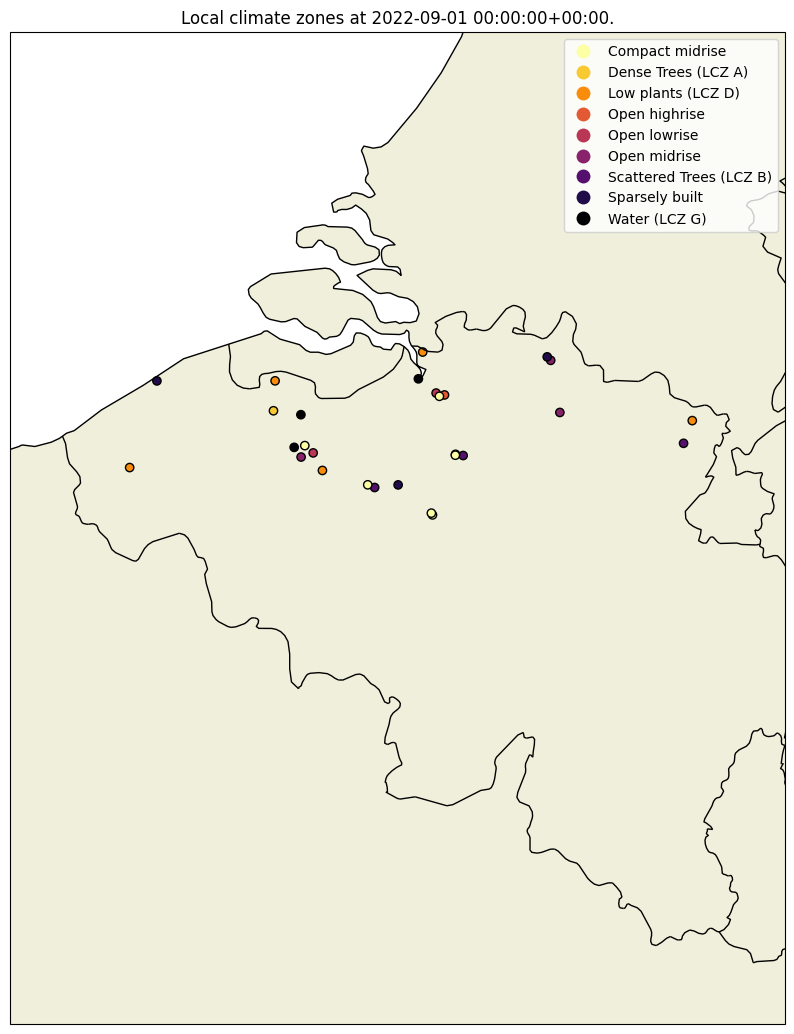

In [5]:
your_dataset.make_geo_plot(variable="lcz")

## Extracting other Geospatial information

Similar as LCZ extraction you can extract the altitude of the stations (from a digital elevation model):

In [6]:
altitudes = your_dataset.get_altitude() #The altitudes are in meters above sea level.
print(altitudes)

name
vlinder01    12
vlinder02     7
vlinder03    30
vlinder04    25
vlinder05     0
vlinder06     0
vlinder07     7
vlinder08     7
vlinder09    19
vlinder10    14
vlinder11     6
vlinder12     9
vlinder13    10
vlinder14     4
vlinder15    41
vlinder16     4
vlinder17    83
vlinder18    35
vlinder19    75
vlinder20    44
vlinder21    19
vlinder22     3
vlinder23     1
vlinder24    12
vlinder25    12
vlinder26    24
vlinder27    12
vlinder28     7
Name: elevation, dtype: int64


A more detailed description of the landcover/land use in the microenvironment can be extracted in the form of landcover fractions in a circular buffer for each station.

You can select to aggregate the landcover classes to water - pervious and impervious, or set aggregation to false to extract the landcover classes as present in the worldcover_10m dataset.

In [7]:
aggregated_landcover = your_dataset.get_landcover(
                                        buffers=[100, 250], # a list of buffer radii in meters
                                        aggregate=True #if True, aggregate landcover classes to the water, pervious and impervious.
                                        )

print(aggregated_landcover)

                            water  pervious  impervious
name      buffer_radius                                
vlinder01 100            0.000000  0.981781    0.018219
          250            0.000000  0.963635    0.036365
vlinder02 100            0.000000  0.428769    0.571231
          250            0.000000  0.535944    0.464056
vlinder03 100            0.000000  0.245454    0.754546
          250            0.000000  0.160831    0.839169
vlinder04 100            0.000000  0.979569    0.020431
          250            0.000000  0.881948    0.118052
vlinder05 100            0.446604  0.224871    0.328525
          250            0.242406  0.526977    0.230617
vlinder06 100            0.000000  1.000000    0.000000
          250            0.000000  0.995819    0.004181
vlinder07 100            0.000000  0.433034    0.566966
          250            0.002911  0.149681    0.847407
vlinder08 100            0.000000  0.029552    0.970448
          250            0.002911  0.030423    0

## Extracting ERA5 timeseries

The toolkit has built-in functionality to extract ERA5 time series at the station locations. The ERA5 data will be stored in a [Modeldata](https://vergauwenthomas.github.io/MetObs_toolkit/intro.html#modeldata) instance. 

A Modeldata stores modeldata in the form of **timeseries at specific locations** (thus not gridded data!). This means that each modeldata must have a `metadf` attribute, where the location of the timeseries is stored. 

In addition, each Modeldata must be linked to an *Extractor*, which handles data extraction from a gridded dataset. The `GeeExtractor` is a class that extracts data from Google Earth Engine dataset.

There are two ways to create ERA5 Modeldata: 1) Constructing it manually (most flexibility) or 2) Let your Dataset construct equivalent Modeldata.

### Constructing ERA5 Modeldata manually

In [8]:
#1. Setup of the GEE extractor

#Create a Gee extractor (this class holds methods for interacting with GEE)
era5_extractor = metobs_toolkit.GeeExtractor()

#Specify that you want to use the ERA5 dataset 
era5_extractor.activate_ERA5()

#2. Setup of the Modeldata object
#Create a Modeldata object (this data object stores timeseries and methods of modeldata).
era5_modeldata = metobs_toolkit.Modeldata(metadf=your_dataset.metadf,
                                          extractor=era5_extractor)
#add an observation as demo
dewpoint_temperature = metobs_toolkit.Obstype(obsname='dewpoint_temp',
                                              std_unit='Celsius',
                                              description='Dewpoint temperature at 2m height',
                                              unit_conversions = {'Kelvin': ['x-273.15']})

#Convert the Obstype into a ModelObstype
dewpoint_temp_modeldata_obstype = metobs_toolkit.ModelObstype(obstype=dewpoint_temperature,
                                                              band_name='dewpoint_temperature_2m', #See ERA5 band names
                                                              band_unit='Kelvin', 
                                                              band_description='Temperature to which the air, at 2 meters above the surface of the Earth, would ... '
                                                             )
#add it to the modeldata
era5_modeldata.add_obstype(dewpoint_temp_modeldata_obstype)

#Extract modeldata
from datetime import datetime
startdt = datetime(2022, 8, 15)
enddt = datetime(2022, 8, 16)
era5_modeldata.import_from_gee(target_obstypes=[era5_modeldata.obstypes['temp'],
                                                dewpoint_temp_modeldata_obstype],
                               start_utc=startdt,
                               end_utc=enddt,
                               gdrive_filename="era5_demo_data")

# What is inside the Modeldata
era5_modeldata.get_info() #prints out info on the content
print(era5_modeldata.obstypes) #see all present Modelobstypes
print(era5_modeldata.df.head()) #See how the data looks like

Modeldata instance linked to GeeExtractor for ERA5 use: 
   location : ECMWF/ERA5_LAND/HOURLY, containing: 
     * 28 timeseries 
     * The following obstypes are available: ['dewpoint_temp', 'temp'] 
     * Data has these units: ['Celsius', 'Celsius'] 
     * From 2022-08-15 00:00:00+00:00 --> 2022-08-16 00:00:00+00:00 (with tz=UTC) 
 
 (Data is stored in the .df attribute)
{'temp': ModelObstype instance of temp, 'pressure': ModelObstype instance of pressure, 'wind': ModelObstype_Vectorfield instance of wind, 'dewpoint_temp': ModelObstype instance of dewpoint_temp}
                                     dewpoint_temp       temp
name      datetime                                           
vlinder01 2022-08-15 00:00:00+00:00      13.414743  22.267374
          2022-08-15 01:00:00+00:00      14.002893  21.614236
          2022-08-15 02:00:00+00:00      15.169229  20.718790
          2022-08-15 03:00:00+00:00      16.197534  20.080621
          2022-08-15 04:00:00+00:00      16.713266  19


### Constructing ERA5 Modeldata from a Dataset
Here an example on how to get the ERA5 time series by using the [get_equivalent_era5_modeldata()](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.dataset_settings_updater.Dataset.html#metobs_toolkit.dataset_settings_updater.Dataset.get_equivalent_era5_modeldata) method of a Dataset.

Modeldata instance linked to GeeExtractor for ERA5 use: 
   location : ECMWF/ERA5_LAND/HOURLY, containing: 
     * 1 timeseries 
     * The following obstypes are available: ['pressure', 'temp', 'u_comp_wind', 'v_comp_wind', 'wind_amplitude', 'wind_direction'] 
     * Data has these units: ['pa', 'Celsius', 'm/s', 'm/s', 'm/s', '° from north (CW)'] 
     * From 2022-09-01 00:00:00+00:00 --> 2022-09-16 00:00:00+00:00 (with tz=UTC) 
 
 (Data is stored in the .df attribute)


<Axes: title={'center': ' ERA5 data for temp from ECMWF/ERA5_LAND/HOURLY \n and temp observations.'}, ylabel='temp (Celsius) \n temperature_2m'>

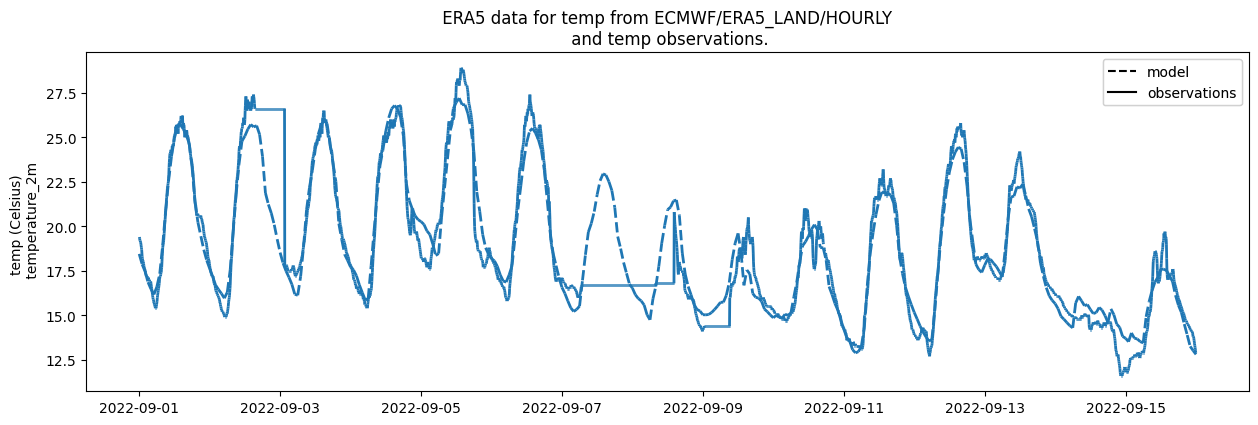

In [9]:
#Get the ERA5 data for a single station (to reduce data transfer)
your_station = your_dataset.get_station('vlinder02')

#Extract time series at the location of the station
ERA5_data = your_station.get_equivalent_era5_modeldata(
                                        get_obstypes='all'
                                      )

#Get info
print(ERA5_data)
ERA5_data.make_plot(obstype_model='temp', 
                    dataset=your_station, #add the observations to the same plot 
                    obstype_dataset='temp')


### GEE data transfer

There is a limit to the amount of data that can be transfered directly from GEE. When the data cannot be transferred directly, **it will be written to a file on your Google Drive**. The location of the file will be printed out. When the writing to the file is done, you must download the file and import it to an empty *Modeldata* instance using the [set_model_from_csv()](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.modeldata.Modeldata.html#metobs_toolkit.modeldata.Modeldata.set_model_from_csv) method. 

In [10]:
#Illustration
#Extract time series at the locations all the station
ERA5_data = your_dataset.get_equivalent_era5_modeldata(
                                            get_obstypes='all'
                                          )

#Because the data amount is too large, it will be written to a file on your Google Drive! The returned Modeldata is empty.
print(ERA5_data)


THE DATA AMOUT IS TO LAREGE FOR INTERACTIVE SESSION, THE DATA WILL BE EXPORTED TO YOUR GOOGLE DRIVE!
The timeseries will be writen to your Drive in era5_timeseries/era5_data 


KeyboardInterrupt: 

In [ ]:
#See the output to find the modeldata in your Google Drive, and download the file.
#Update the empty Modeldata with the data from the file

#ERA5_data.set_model_from_csv(csvpath='/home/..../era5_data.csv') #The path to the downloaded file
#print(ERA5_data)

## Interactive plotting of a GEE dataset

You can make an interactive spatial plot to visualize the stations spatially by using the [make_gee_plot()](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.dataset.Dataset.html#metobs_toolkit.dataset.Dataset.make_gee_plot).

In [12]:
landcovers = metobs_toolkit.GeeExtractor()
landcovers.activate_worldcover()

spatial_map = landcovers.make_gee_plot(metadf = your_dataset.metadf)
spatial_map